## NLP beginning exercises
Including:
* Tokenization
* Embedding
* Different types of layers/nets
* Functional keras

based on: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb

### Dataset loading an imports

In [23]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import random

In [4]:
train_path = './datasets/nlp_disaster/train.csv'
test_path = './datasets/nlp_disaster/test.csv'

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_df_shuffled = train_df.sample(frac=1)
train_df_shuffled.head()

,id,keyword,location,text,target
4241,6026,hazardous,NaN,MTR issues Hazardous Weather Outlook (HWO) htt...,1
6802,9745,tragedy,NaN,Robert Gagnon reviews the catastrophe of impos...,1
5099,7274,nuclear%20disaster,NaN,3 Former Executives To Be Prosecuted In Fukush...,1
1318,1905,burning,NaN,@nagel_ashley @Vicken52 @BasedLaRock @goonc1ty...,0
724,1045,bleeding,dmv ?? fashion school @ KSU.,i hit my foot now my toe is bleeding ??,0


In [10]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

### Visualize random samples

In [17]:
random_index = random.randint(0, len(train_df)-3)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+3].itertuples():
    ind, text, target = row
    print(f'target: {"disaster" if target > 0 else "not disaster"}')
    print(f'\n{text}\n')
    # print(f'ind: {ind}')
    print('---\n')

target: disaster

#computers #gadgets Two giant cranes holding a bridge collapse into nearby homes http://t.co/UZIWgZRynY #slingnews

---

target: not disaster

Reddit Will Now Quarantine Offensive Content http://t.co/LOdOrmTfSq

---

target: disaster

b/c it costs less to have sick people using emergency rooms?...grrrr.... http://t.co/vFbbcHwrFD

---



### Create a validation set as the test set is for competition entrances, and it doesn't have a target column

In [19]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size = 0.1)

In [20]:
len(train_sentences), len(val_sentences)

(6851, 762)

In [26]:
from tensorflow.keras.layers import TextVectorization

#### Text vectorization

In [31]:
# Find average number of tokens (words) in training Tweets
avg_words = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [45]:
max_vocab_len = 10000
max_sentence_len = avg_words

In [46]:
# here we're initializing a tokenizer with a set output sequence lenght (to help with batching)
# plus we're setting max_tokens to limit the tokens considered to the 10000 most common ones
text_vectorizer = TextVectorization(max_tokens=max_vocab_len,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=max_sentence_len
                                   )

##### you have to fit (adapt) a vectorizer to your data

In [52]:
text_vectorizer.adapt(train_sentences)

In [53]:
# test the vectorizer
sample_sentence = random.choice(train_sentences)
print(sample_sentence)
print(text_vectorizer([sample_sentence]))

Are people not concerned that after #SLAB's obliteration in Scotland #Labour UK is ripping itself apart over #Labourleadership contest?
tf.Tensor(
[[  21   57   33 1704   17   38 8393  511    4 3429 5200  981    9 9034
  2084]], shape=(1, 15), dtype=int64)


In [41]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['ovofest', 'ovo', 'overåÊhostages', 'overzero', 'overwhelming']


#### Embedding

In [42]:
from tensorflow.keras import layers

In [43]:
# len of embedding vectors
embed_len = 128

In [47]:
embedding = layers.Embedding(input_dim=max_vocab_len, # set input shape
                             output_dim=embed_len, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_sentence_len, # how long is each input
                             name="embedding_1") 

embedding

In [54]:
# test the embedder
# each tokken gets embedded into a vector
sample_sentence = random.choice(train_sentences)
print(sample_sentence)
sample_embed = embedding(text_vectorizer([sample_sentence]))
sample_embed

I would like to electrocute everyone who uses the word 'fair' in connection with income tax policies. - William F. Buckley Jr.


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0486181 ,  0.04681425,  0.01941798, ..., -0.0259532 ,
         -0.03178634,  0.03056673],
        [-0.03503084, -0.03483643, -0.03200938, ..., -0.0245998 ,
          0.0182102 , -0.00779082],
        [-0.04591447, -0.04023138, -0.04675725, ..., -0.02857027,
         -0.00123527,  0.02125475],
        ...,
        [ 0.0182826 ,  0.01587267, -0.02455018, ...,  0.04657182,
         -0.0348844 , -0.04203259],
        [ 0.02937689,  0.01791295, -0.04557009, ...,  0.01946897,
         -0.0269248 ,  0.00549157],
        [ 0.04779092,  0.01424534, -0.0093229 , ..., -0.04571698,
         -0.02980891, -0.04442218]]], dtype=float32)>

In [55]:
sample_embed.shape

TensorShape([1, 15, 128])

### Baseline model - tf/idf term weighting

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [57]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 77.95%


### Function to evaluate models on a classification task
with accuracy, precision, recall, f1-score

In [58]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [60]:
# Get baseline results
baseline_preds = model_0.predict(val_sentences)

baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 77.95275590551181,
 'precision': 0.7915472508475033,
 'recall': 0.7795275590551181,
 'f1': 0.7694175813079408}

### A simple Dense model
(functional)

In [62]:
# inputs are 1D vectors of dtype="string" [validation]
inputs = layers.Input(shape=(1,), dtype="string")
# vectorize
x = text_vectorizer(inputs)
# embed
x = embedding(x)
# embedding returns (1,15,128) - 15 for each token, 128 for vector len,
# we want a prediction for the whole sentence so we have to compile these results
# with average or max pooling (1D)
x = layers.GlobalAveragePooling1D()(x) #(x) outside as per documentation
# binary classification therefore 1 output neuron and sigmoid
outputs = layers.Dense(1, activation='sigmoid')(x)

# create model from functional layers
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [63]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy',])

In [64]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [65]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                             )

Epoch 1/5

215/215 [==============================] - 2s 6ms/step - loss: 0.6127 - accuracy: 0.6945 - val_loss: 0.5393 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4425 - accuracy: 0.8162 - val_loss: 0.4727 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3497 - accuracy: 0.8602 - val_loss: 0.4562 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2871 - accuracy: 0.8899 - val_loss: 0.4557 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2399 - accuracy: 0.9120 - val_loss: 0.4704 - val_accuracy: 0.7940


#### Model results

#### Important note: As we're using a sigmoid output, to get prediction classes, we need to round the prediction values (probabilities) [or in multiclass choose the highest one from the prediction prob array and then round]
then also squeeze the dimension for comparison reasons

In [68]:
model_1_preds = tf.squeeze(tf.round(model_1.predict(val_sentences)))

24/24 [==============================] - 0s 913us/step


In [69]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [70]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.7928903507036981,
 'recall': 0.7939632545931758,
 'f1': 0.7920589507063273}

In [71]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 77.95, New accuracy: 79.40, Difference: 1.44
Baseline precision: 0.79, New precision: 0.79, Difference: 0.00
Baseline recall: 0.78, New recall: 0.79, Difference: 0.01
Baseline f1: 0.77, New f1: 0.79, Difference: 0.02


### RNNs

### LSTM

#### Note: because we use embeddings as layers, they get trained during model fitting
to combat that, we have to create a separate embedding layer for each model

In [73]:
model_2_embedding = layers.Embedding(input_dim=max_vocab_len, # set input shape
                             output_dim=embed_len, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_sentence_len, # how long is each input
                             name="embedding_2") 

In [74]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.LSTM(units=64)(x)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN layers)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [75]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [77]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                                )

Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.5057 - accuracy: 0.7484 - val_loss: 0.4769 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3191 - accuracy: 0.8675 - val_loss: 0.4589 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2200 - accuracy: 0.9161 - val_loss: 0.5938 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1565 - accuracy: 0.9425 - val_loss: 0.6723 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1053 - accuracy: 0.9610 - val_loss: 0.9579 - val_accuracy: 0.7362


In [78]:
model_2_pred_probs = model_2.predict(val_sentences)
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 73.62204724409449,
 'precision': 0.7434830367281546,
 'recall': 0.7362204724409449,
 'f1': 0.7379301831916483}

### Other RNN layers to try: GRU, Bidirectional RNN/LSTM

### Could also use 1D CNNs

### Pretrained embeddings / transfer learning for NLP

https://tfhub.dev/google/universal-sentence-encoder/4

In [80]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.03491368 -0.05202626 -0.0165102  -0.08337957 -0.01891575 -0.07866167
 -0.05584712 -0.05938221  0.02887729 -0.06164343  0.00379627 -0.0170562
 -0.02297798 -0.04288733 -0.0446399  -0.07259919 -0.03284239  0.00814521
 -0.06901841 -0.00363603 -0.05164122 -0.02577795  0.03388479 -0.0409942
 -0.07960071  0.02076143  0.0700054   0.01461454  0.04525214 -0.02656616
  0.00033423 -0.04028461  0.0391934   0.05764904 -0.00947513 -0.05555471
  0.06020658 -0.01631964  0.00075163 -0.03646719  0.05976842 -0.06878553
  0.03679937  0.02036367  0.00862888  0.07077238 -0.05169178 -0.05026665
 -0.05757866 -0.08680485], shape=(50,), dtype=float32)


In [81]:
embed_samples[0].shape

TensorShape([512])

#### The downloaded pre-trained weights are the encoder
let's create a layer based on them

In [82]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

Sequential

In [ ]:
# Create model using the Sequential API
# model_6 = tf.keras.Sequential([
#   sentence_encoder_layer, # take in sentences and then encode them into an embedding
#   layers.Dense(64, activation="relu"),
#   layers.Dense(1, activation="sigmoid")
# ], name="model_6_USE")

Functional attempt 1 (nvm)

In [89]:
# inputs = layers.Input(input_shape=(1,), dtype="string"
# no inputs layer, already included in the encoding layer
# inputs = sentence_encoder_layer
# x = layers.Dense(64, activation='relu')(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)

# model_6 = tf.keras.Model(inputs, outputs, name="model_6_USE")

https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/

Functional attempt 2

In [91]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                    trainable=False)(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_6 = tf.keras.models.Model(inputs, outputs, name="model_6_USE")

In [92]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [93]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
215/215 [==============================] - 3s 5ms/step - loss: 0.5050 - accuracy: 0.7876 - val_loss: 0.4475 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4156 - accuracy: 0.8158 - val_loss: 0.4336 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4018 - accuracy: 0.8219 - val_loss: 0.4275 - val_accuracy: 0.8018
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3926 - accuracy: 0.8270 - val_loss: 0.4246 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3856 - accuracy: 0.8308 - val_loss: 0.4208 - val_accuracy: 0.8097


In [94]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 80.97112860892388,
 'precision': 0.809695567195205,
 'recall': 0.8097112860892388,
 'f1': 0.8072289690741726}

### Compare model results

In [95]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,77.952756,0.791547,0.779528,0.769418
simple_dense,79.396325,0.792890,0.793963,0.792059
lstm,73.622047,0.743483,0.736220,0.737930
tf_hub_sentence_encoder,80.971129,0.809696,0.809711,0.807229


In [96]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

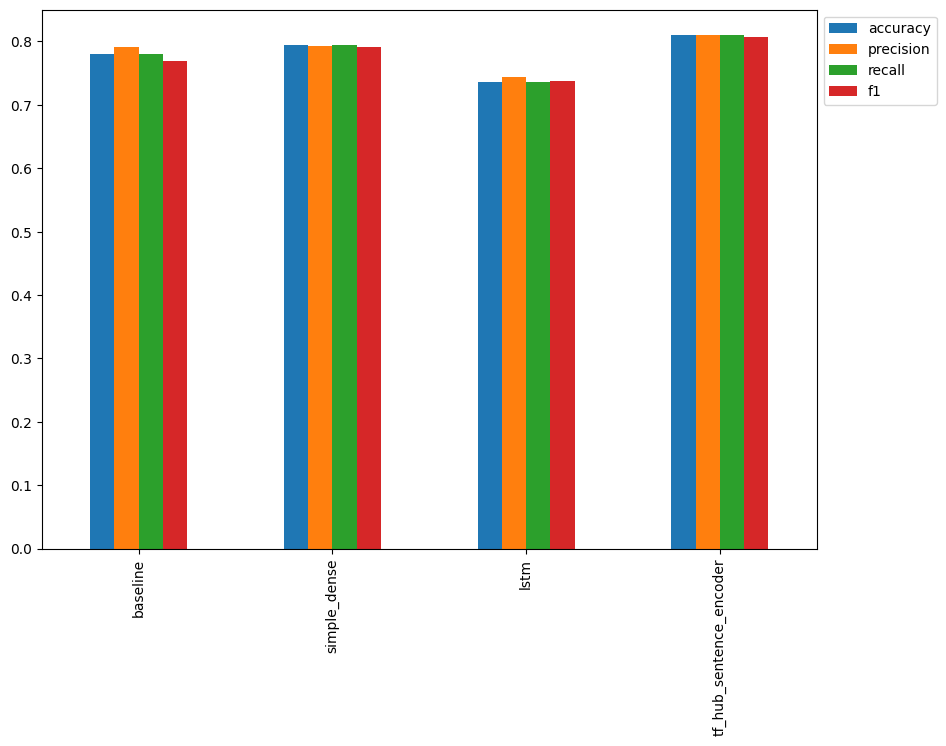

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

### Extra - model ensembling
using averaging of predictions from out multiple models

In [98]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1.], dtype=float32)>

In [99]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 74.80314960629921,
 'precision': 0.7675144733356206,
 'recall': 0.7480314960629921,
 'f1': 0.74993726780156}

#### In our case - not really an improvement

### Save the best model

In [101]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6_USE_distaster")

INFO:tensorflow:Assets written to: model_6_USE_distaster\assets


INFO:tensorflow:Assets written to: model_6_USE_distaster\assets


### Additional prediction / performance explorations

In [102]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,@RyleeDowns02 @nevaehburton33 if I don't get m...,0,0.0,0.241386
1,A deluge of eulogies for #CecilTheLion on my ...,0,0.0,0.144588
2,An Eau Claire man who police said was drunk wh...,1,1.0,0.976626
3,Images of Famine ÛÒ Hope In Christ - A blog o...,1,0.0,0.364708
4,#PBBan (Temporary:300) fighterdena @'aRmageddo...,0,1.0,0.651767


In [103]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
535,09:13 PM: Hazardous Weather Outlook (http://t...,0,1.0,0.911499
710,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.909534
133,Beautiful lightning as seen from plane window ...,0,1.0,0.902969
151,The first trial in the death of #CecilTheLion ...,0,1.0,0.892217
683,@CNN the End of Times are upon us. Famine War ...,0,1.0,0.868433
154,Google Alert: Emergency units simulate a chemi...,0,1.0,0.863457
458,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,1.0,0.841473
747,On Thursday at 00:25 we updated our #kml of 2D...,0,1.0,0.818817
203,http://t.co/eHKLp12yiP Paci?c Media Centre | a...,0,1.0,0.810652
319,Do you want to play a game?\nhttp://t.co/sQFp6...,0,1.0,0.809695


In [104]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9114993810653687
Text:
09:13 PM:  Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy

----

Target: 0, Pred: 1, Prob: 0.9095335006713867
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9029689431190491
Text:
Beautiful lightning as seen from plane window http://t.co/5CwUyLnFUm http://t.co/1tyYqFz13D

----

Target: 0, Pred: 1, Prob: 0.8922174572944641
Text:
The first trial in the death of #CecilTheLion was just postponed http://t.co/fnmJE8GF7m http://t.co/nYe8ae2ifr

----

Target: 0, Pred: 1, Prob: 0.8684331774711609
Text:
@CNN the End of Times are upon us. Famine War Death Plague. The presence is growing stronger.

----

Target: 0, Pred: 1, Prob: 0.8634571433067322
Text:
Google Alert: Emergency units simulate a chemical explosion at NU http://t.co/NDgpWYxu6H

----

Target: 0, Pred: 1, Prob: 0.8414732217788696
Text:
On plus s

In [105]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.08835342526435852
Text:
Dad bought a DVD that looks like a science doc on the front but I read the back and it's actually about the impending biblical apocalypse

----

Target: 1, Pred: 0, Prob: 0.08612692356109619
Text:
Perspectives on the Grateful Dead: Critical Writings (Contributions to the Study http://t.co/fmu0fnuMxf http://t.co/AgGRyhVXKr

----

Target: 1, Pred: 0, Prob: 0.08011748641729355
Text:
'Money can't buy happiness' is just a lie we tell poor people to keep them from rioting.

----

Target: 1, Pred: 0, Prob: 0.07660643011331558
Text:
I feel like if MKayla and Cee ever got in the same room everyone should evacuate because it would be so petty and childish I couldn't deal

----

Target: 1, Pred: 0, Prob: 0.0688488781452179
Text:
@gilderoy i wish i was good enough to add flames to my nails im on fire

----

Target: 1, Pred: 0, Prob: 0.06554054468870163
Text:
Enjoying a little golf this summer? Take care to avoid injury -- back and shoulder injuri